Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import math
import scipy
from PIL import Image
import tensorflow as tf
import keras
import keras.layers
from matplotlib.pyplot import imread
import h5py

Adding file from path

In [2]:
trainFile = h5py.File('./train_happy.h5')
testFile = h5py.File('./test_happy.h5')

Visualising the train and test data

In [3]:
x_train = np.array(trainFile['train_set_x'][:])
y_train = np.array(trainFile['train_set_y'][:])

X_test = np.array(testFile['test_set_x'][:])
y_test = np.array(testFile['test_set_y'][:])

print ("number of training samples = " + str(x_train.shape[0]))
print ("number of test samples = " + str(X_test.shape[0]))
print ("x_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training samples = 600
number of test samples = 150
x_train shape: (600, 64, 64, 3)
Y_train shape: (600,)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150,)


In [4]:
y_train = y_train.reshape((1, y_train.shape[0]))
y_test = y_test.reshape((1, y_test.shape[0]))
print(y_train.shape)

x_train = x_train / 255.0
x_test = X_test / 255.0

y_train = y_train.T
y_test = y_test.T
print(y_train.shape)

(1, 600)
(600, 1)


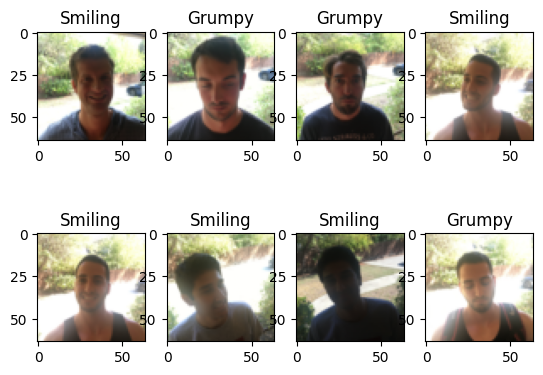

In [5]:
fig, axes = plt.subplots(2, 4)
for i in range(2):
    for j in range(4):
        index = np.random.randint(0, x_train.shape[0])
        axes[i, j].imshow(x_train[index])
        if y_train[index]==1:
            axes[i, j].set_title('Smiling')
        else:
            axes[i, j].set_title('Grumpy')
        axes[i, j].axis('on')
plt.show()

Splitting the data

In [6]:
from sklearn.model_selection import train_test_split
# Split the data into training and validation sets
X_train, x_val, Y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(f"Training data: X_train {X_train.shape}, y_train {Y_train.shape}")
print(f"Validation data: X_val {x_val.shape}, y_val {y_val.shape}")

Training data: X_train (480, 64, 64, 3), y_train (480, 1)
Validation data: X_val (120, 64, 64, 3), y_val (120, 1)


Augmenting the data and displaying it (AUGMENTING THE DATA HERE REDUCED THE ACCURACY SO COMMENTED IT, COULD TRY OPTIMIZING IT FOR AUGMENTATION)

In [7]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_data_gen = ImageDataGenerator(
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     vertical_flip=True,
#     fill_mode='constant',
#     cval=0,
#     horizontal_flip=True,
#     rotation_range=50,
#     zoom_range=0.3,
#     validation_split=0.15
# )

# val_data_gen = ImageDataGenerator()

# test_data_gen = ImageDataGenerator()

# Batch_size = 8

In [8]:
# train_generator = train_data_gen.flow(X_train,Y_train,batch_size=Batch_size)
# val_generator = train_data_gen.flow(x_val,y_val,batch_size=Batch_size)
# test_generator = train_data_gen.flow(X_test,y_test,batch_size=Batch_size)

In [9]:
# def show_batch(image_batch, label_batch):
#   plt.figure(figsize=(35,40))
#   for n in range(8):

#     ax = plt.subplot(1,8,n+1)
#     plt.imshow(image_batch[n])

#     if label_batch[n]==1:
#       ax.set_title('Smiling')
#     else:
#       ax.set_title('Grumpy')
#     plt.axis('off')

# image_batch, label_batch = next(train_generator)
# show_batch(image_batch, label_batch)

Building the main model layers

In [10]:
input=x_train.shape[1:]

In [11]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.layers import Activation

model= Sequential()
model.add(Conv2D(24, (3,3), padding='valid', input_shape=input))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(28, (3,3), padding='valid' ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), padding='valid' ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='valid' ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))


model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 24)        672       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 24)        96        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 62, 62, 24)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 24)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 28)        6076      
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 28)       

Implementing some optimization methods like callbacks and checkpoints

In [12]:
from keras.metrics import Recall,Precision,AUC

Optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              metrics=['accuracy',Precision(),Recall(),AUC()],
              optimizer=Optimizer)

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

filepath = './best_weights.hdf5'

tensorboard_callback = TensorBoard("logs")

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 8,
                              verbose = 1)

checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose = 1)
lrr = ReduceLROnPlateau(monitor='val_loss',
                        patience=2,
                        verbose=1,
                        factor=0.2,
                        min_lr=0.00001)

callback_list = [earlystopping, checkpoint, tensorboard_callback, lrr]

Fitting and training the model

In [14]:
history = model.fit(
    X_train, Y_train,  
    epochs=120,
    validation_data=(x_val, y_val), 
    batch_size=8,
    verbose=2,
    callbacks=callback_list
)

Epoch 1/120



Epoch 1: val_accuracy improved from -inf to 0.44167, saving model to .\best_weights.hdf5
60/60 - 4s - loss: 0.7126 - accuracy: 0.6792 - precision: 0.6725 - recall: 0.6609 - auc: 0.7353 - val_loss: 0.7867 - val_accuracy: 0.4417 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5818 - lr: 0.0010 - 4s/epoch - 66ms/step
Epoch 2/120


C:\Users\KIIT\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.44167
60/60 - 1s - loss: 0.3799 - accuracy: 0.8396 - precision: 0.8421 - recall: 0.8240 - auc: 0.9142 - val_loss: 1.3539 - val_accuracy: 0.4417 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7064 - lr: 0.0010 - 959ms/epoch - 16ms/step
Epoch 3/120

Epoch 3: val_accuracy did not improve from 0.44167

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
60/60 - 1s - loss: 0.2387 - accuracy: 0.8958 - precision: 0.8961 - recall: 0.8884 - auc: 0.9666 - val_loss: 3.0851 - val_accuracy: 0.4417 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6269 - lr: 0.0010 - 853ms/epoch - 14ms/step
Epoch 4/120

Epoch 4: val_accuracy did not improve from 0.44167
60/60 - 1s - loss: 0.0908 - accuracy: 0.9729 - precision: 0.9701 - recall: 0.9742 - auc: 0.9931 - val_loss: 2.3768 - val_accuracy: 0.4417 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8730 - lr: 2.0000e-04 - 900ms/epoch - 15ms

In [15]:
# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

# model_history = model.fit_generator(generator=train_generator,
#                    steps_per_epoch=STEP_SIZE_TRAIN,
#                    validation_data=val_generator,
#                    validation_steps=STEP_SIZE_VALID,
#                    epochs=120,
#                    callbacks=callback_list)

Tensorboard visualisation

In [16]:
%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 19056), started 0:59:17 ago. (Use '!kill 19056' to kill it.)

Saving the model and Plotting visualisation of simple metrics

In [17]:
model.save('./best_weights.hdf5')

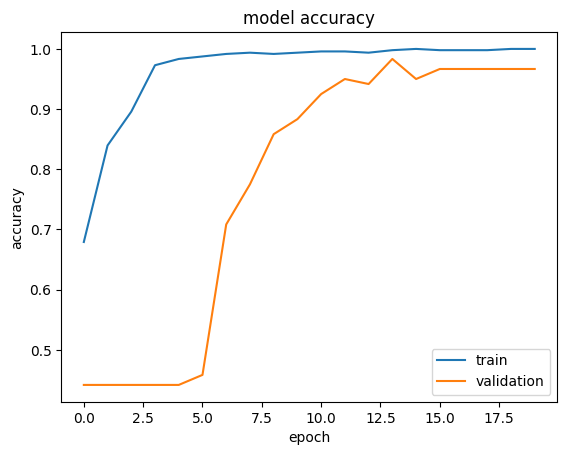

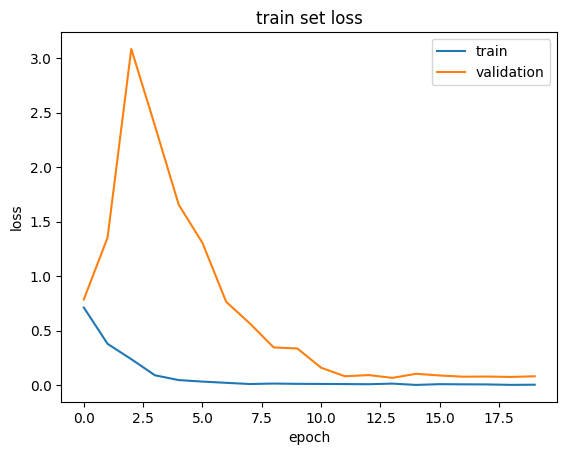

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [19]:
loss, accuracy , precision, recall, auc = model.evaluate(x_test, y_test)
print('Test Accuracy: %.3f' % accuracy)
print('Test Precision: %.3f' % precision)
print('Test Recall: %.3f' % recall)
print('Test loss: %.3f' % loss)
print('Test AUC score: %.3f' % auc)

5/5 [==============================] - 0s 15ms/step - loss: 0.1874 - accuracy: 0.9533 - precision: 0.9753 - recall: 0.9405 - auc: 0.9899
Test Accuracy: 0.953
Test Precision: 0.975
Test Recall: 0.940
Test loss: 0.187
Test AUC score: 0.990
